### Change log

#### 04/29
- did analysis on Beijing air quality data
- analysis on Beijing meo data

#### 05/03
- moved project to new folder
- investigate on missing data negative values

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from utils.data_utils import bj_particles, get_stations
from utils.STMVL import STMVL
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

### Beijing Air Quality Data

#### Load data

In [12]:
particles_aq = {}
for particle in bj_particles:
    data = pd.read_csv(r'./Data/{}_filled.csv'.format(particle), index_col=0)
    particles_aq[particle] = data
particles_aq['PM2.5'].shape

(11568, 35)

In [9]:
pm25 = particles_aq['PM2.5']
# drop missing rows
pm25.dropna(inplace=True)

#### Correlation between different stations

In [14]:
stations = get_stations()

In [18]:
stations.head()

,stationId,longitude,latitude
0,dongsi_aq,116.417,39.929
1,tiantan_aq,116.407,39.886
2,guanyuan_aq,116.339,39.929
3,wanshouxigong_aq,116.352,39.878
4,aotizhongxin_aq,116.397,39.982


In [19]:
pm25.head()

,aotizhongxin_aq_PM2.5,badaling_aq_PM2.5,beibuxinqu_aq_PM2.5,daxing_aq_PM2.5,dingling_aq_PM2.5,donggaocun_aq_PM2.5,dongsi_aq_PM2.5,dongsihuan_aq_PM2.5,fangshan_aq_PM2.5,fengtaihuayuan_aq_PM2.5,...,wanliu_aq_PM2.5,wanshouxigong_aq_PM2.5,xizhimenbei_aq_PM2.5,yanqin_aq_PM2.5,yizhuang_aq_PM2.5,yongdingmennei_aq_PM2.5,yongledian_aq_PM2.5,yufa_aq_PM2.5,yungang_aq_PM2.5,zhiwuyuan_aq_PM2.5
2017-01-01 14:00:00,453.0,87.0,479.0,352.0,339.0,377.0,469.0,390.0,399.0,391.0,...,468.0,416.0,514.0,206.0,278.0,415.0,329.0,285.0,415.0,458.0
2017-01-01 15:00:00,417.0,58.0,481.0,375.0,343.0,387.0,470.0,390.0,397.0,393.0,...,459.0,403.0,508.0,218.0,298.0,409.0,317.0,302.0,423.0,442.0
2017-01-01 16:00:00,395.0,30.0,488.0,364.0,311.0,351.0,458.0,374.0,429.0,403.0,...,441.0,389.0,497.0,146.0,306.0,401.0,326.0,302.0,449.0,441.0
2017-01-01 17:00:00,420.0,23.0,487.0,337.0,256.0,274.0,477.0,401.0,441.0,414.0,...,445.0,403.0,500.0,134.0,306.0,407.0,345.0,316.0,469.0,241.0
2017-01-01 18:00:00,453.0,20.0,489.0,329.0,57.0,200.0,467.0,408.0,438.0,409.0,...,440.0,413.0,480.0,175.0,315.0,415.0,356.0,336.0,421.0,13.0


In [48]:
def caculate_r_distance_relations(df, stations):
    relations = pd.DataFrame(columns=["station_1", "station_2", "r", "distance"])
    num_cols = df.shape[1]
    cols = df.columns.tolist()
    for i in range(num_cols):
        for j in range(i+1, num_cols):
            station_1 = cols[i]
            station_2 = cols[j]
            
            ts_station_1 = df[station_1]
            ts_station_2 = df[station_2]
            
            s1 = station_1.rsplit("_", maxsplit=1)[0]
            s2 = station_2.rsplit("_", maxsplit=1)[0]
            
            lat1, lng1 = stations.loc[stations['stationId'] == s1, ['latitude', 'longitude']].iloc[0, :]            
            lat2, lng2 = stations.loc[stations['stationId'] == s2, ['latitude', 'longitude']].iloc[0, :]            
            
            r = pearsonr(ts_station_1, ts_station_2)[0]
            distance = STMVL.geo_distance(lat1, lng1, lat2, lng2)
            s = pd.Series({"station_1":s1, "station_2":s2, "r":r, "distance":distance})
            relations = relations.append(s,ignore_index=True)
    
    # 按照相关系数降序排序
    relations = relations.sort_values(by=['r'], ascending=False)
    plt.subplot(2,1,1)
    plt.plot(range(len(relations)), relations['r']);
    plt.subplot(2,1,2)
    plt.plot(range(len(relations)), relations['distance']);

    # “相关系数的降低” 与 “站点之间的距离” 存在一定的正相关关系
    # “距离” 与 “相关性” 存在负相关关系
    # print("The range of pearsonr between stations of feature %s are between %d and %d" %(feature, relations["r"].values.min(), relations["r"].values.max()))
    
    r = pearsonr(relations["r"].values, relations['distance'].values)[0]
    # print("r = ", pearsonr(relations["r"].values, relations['distance'].values)[0])
    
    return relations, r

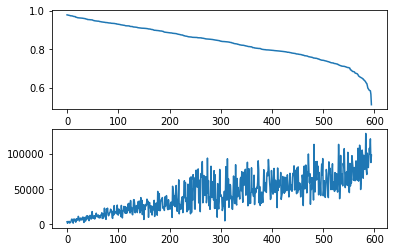

In [49]:
relations, r = caculate_r_distance_relations(pm25, stations)

### Changes of particle concentration along a day

In [100]:
def feature_trend_in_a_day(df):
    
    # initial values
    d = timedelta(hours=24)
    t_start = datetime(2017,1,2,0,0,0)
    t_end = datetime(2017,1,3,0,0,0)
    
    min_date = datetime.strptime(df.index.min(), '%Y-%m-%d %H:%M:%S')
    max_date = datetime.strptime(df.index.max(), '%Y-%m-%d %H:%M:%S')
    total_days = (max_date - min_date).days
    
    all_days = []
    all_days_dfs = []
    for i in range(total_days):
        df_part = df[df.index < datetime.strftime(t_end, '%Y-%m-%d %H:%M:%S')]
        df_part = df_part[df_part.index >= datetime.strftime(t_start, '%Y-%m-%d %H:%M:%S')]

        all_days.append(df_part.values)
        all_days_dfs.append(df_part)
        t_start += d
        t_end += d

    bias_all_days = []
    for day in all_days:
        if len(day) == 24 : 
            init = day[0]
            bias_day = [i - init for i in day]
            bias_all_days.append(bias_day)

    # for bias_all_day in bias_all_days:
    #     plt.plot(bias_all_day)

    bias_all_days = np.array(bias_all_days)
    day = np.mean(bias_all_days, axis=0)
    plt.plot(day)

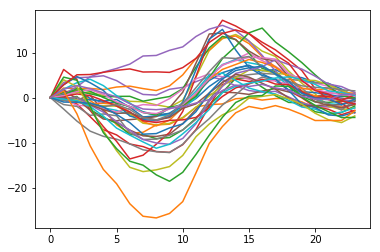

In [101]:
feature_trend_in_a_day(pm25)

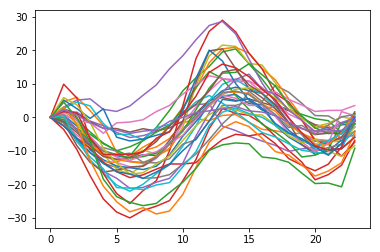

In [102]:
pm10 = particles_aq['PM10']
pm10.dropna(inplace=True)
feature_trend_in_a_day(pm10)

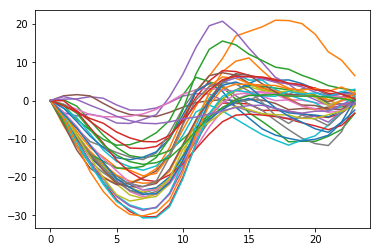

In [103]:
no2 = particles_aq['NO2']
no2.dropna(inplace=True)
feature_trend_in_a_day(no2)

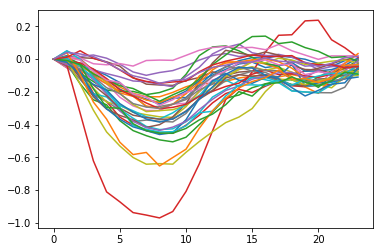

In [104]:
co = particles_aq['CO']
co.dropna(inplace=True)
feature_trend_in_a_day(co)

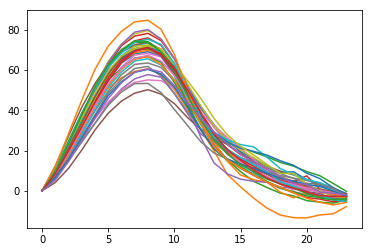

In [105]:
o3 = particles_aq['O3']
o3.dropna(inplace=True)
feature_trend_in_a_day(o3)

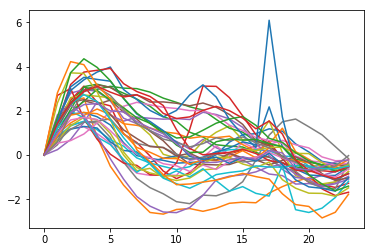

In [106]:
so2 = particles_aq['SO2']
so2.dropna(inplace=True)
feature_trend_in_a_day(so2)

### Beijing Meo Data

In [5]:
bj_grid_meo_hist = pd.read_csv("./Data/Beijing/Beijing_historical_meo_grid.csv")
bj_meo_hist = pd.read_csv("./Data/Beijing/beijing_17_18_meo.csv")
stations = pd.read_excel("./Data/Beijing/Beijing_AirQuality_Stations_locations.xlsx")

In [6]:
bj_grid_meo_hist.head()

,stationName,longitude,latitude,utc_time,temperature,pressure,humidity,wind_direction,wind_speed/kph
0,beijing_grid_000,115.0,39.0,2017-01-01 00:00:00,-5.47,984.73,76.60,53.71,3.53
1,beijing_grid_001,115.0,39.1,2017-01-01 00:00:00,-5.53,979.33,75.40,43.59,3.11
2,beijing_grid_002,115.0,39.2,2017-01-01 00:00:00,-5.70,963.14,71.80,0.97,2.75
3,beijing_grid_003,115.0,39.3,2017-01-01 00:00:00,-5.88,946.94,68.20,327.65,3.84
4,beijing_grid_004,115.0,39.4,2017-01-01 00:00:00,-5.34,928.80,58.81,317.85,6.14


#### Compare station names in sample submission with aq data

In [14]:
stations = pd.read_csv(r'./Data/bj_sample_submissioin.csv')['test_id'].str.split('#', expand=True)[0].unique()

In [18]:
stations_other = get_stations('bj')['stationId'].values

In [19]:
np.setdiff1d(stations, stations_other)

array(['aotizhongx_aq', 'fengtaihua_aq', 'miyunshuik_aq', 'nongzhangu_aq',
       'wanshouxig_aq', 'xizhimenbe_aq', 'yongdingme_aq'], dtype=object)